In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, init_to_feasible, util, MCMC, NUTS
import numpyro.infer.autoguide as autoguide
import optax
import matplotlib.pyplot as plt

### Revisting the hidden coin problem! 😀

In this review, we will try to learn the `latent variable`, namely the bias of the coin, from the observed data. 

We will use `numpyro` to do this. There are two major ways to do this:
1. Using `MCMC`
2. Using `SVI`, with this we have to define a guide function. Or using `AutoGuide` which will automatically define a guide function for us.

### Using `SVI` with `AutoGuide` or custom guide function

In [2]:
def model(data: jnp.ndarray | None = None):
    # Flip the coin.
    p = numpyro.sample("p", dist.TruncatedNormal(0.5, 0.1, low=0, high=1))
    return numpyro.sample("coin", dist.BernoulliProbs(probs=p), obs=data)


def custom_guide(data: jnp.ndarray | None = None):
    p_loc = numpyro.param("p_loc", 0.5)
    p_scale = numpyro.param("p_scale", 0.1, constraint=dist.constraints.positive)

    numpyro.sample("p", dist.TruncatedNormal(p_loc, p_scale, low=0, high=1))

    # ! With obs arg, it will resulting in wrong result.
    # ! Also, there is a user warning that
    # ! Currently Trace_ELBO is not support for discrete latent variables. Though the result is correct.
    # numpyro.sample("coin", dist.BernoulliProbs(probs=p))


data = jax.random.bernoulli(jax.random.key(0), 0.75, shape=(1000,))
data = jnp.array(data, dtype=jnp.float32)

optimizer = numpyro.optim.optax_to_numpyro(optax.adam(0.01))
auto_guide = autoguide.AutoNormal(model, init_loc_fn=init_to_feasible)

IS_AUTO_GUIDE = False
if IS_AUTO_GUIDE:
    guide = auto_guide
else:
    guide = custom_guide

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.key(0), num_steps=10000, data=data)

100%|██████████| 10000/10000 [00:01<00:00, 7461.89it/s, init loss: 704.8555, avg. loss [9501-10000]: 549.7459]


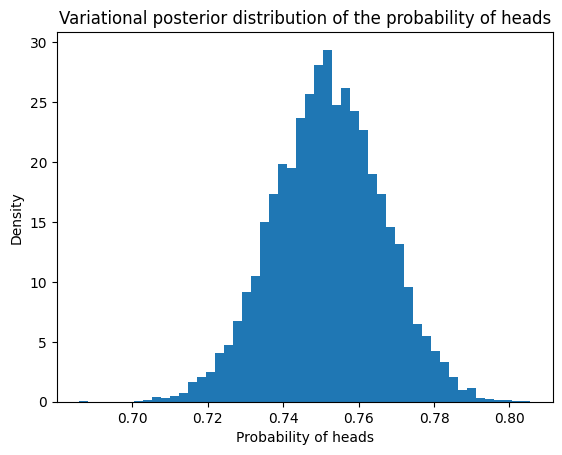

In [3]:
params = svi_result.params

# Sample from the variational distribution
if IS_AUTO_GUIDE:
    assert isinstance(guide, autoguide.AutoNormal)
    posterior_samples = guide.sample_posterior(
        jax.random.key(1), params, sample_shape=(10000,)
    )
else:
    posterior_samples = util._predictive(
        jax.random.key(0),
        numpyro.handlers.substitute(guide, params),
        {},
        batch_shape=(10000,),
        parallel=False,
    )
assert isinstance(posterior_samples, dict)
# Analyze the posterior samples

plt.hist(posterior_samples["p"], bins=50, density=True)
plt.xlabel("Probability of heads")
plt.ylabel("Density")
plt.title("Variational posterior distribution of the probability of heads")
plt.show()

### Using `MCMC` with `NUTS` 

sample: 100%|██████████| 3000/3000 [00:00<00:00, 3567.00it/s, 3 steps of size 8.72e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   p_heads      0.76      0.01      0.76      0.74      0.78    606.55      1.01

Number of divergences: 0


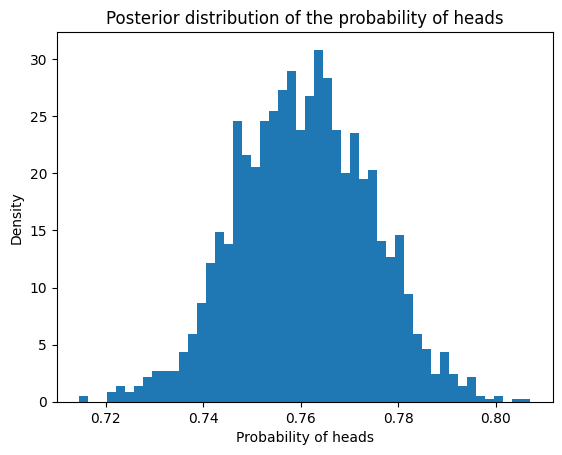

In [4]:
# Define the model
def coin_flip_model(data):
    # Prior for the probability of heads
    p_heads = numpyro.sample(
        "p_heads", dist.TruncatedNormal(loc=0.5, scale=0.1, low=0.0, high=1.0)
    )
    # Likelihood of the observed data
    numpyro.sample("obs", dist.Bernoulli(p_heads), obs=data)


# Set up the MCMC sampler
nuts_kernel = NUTS(coin_flip_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)

# Run the MCMC sampler
rng_key = jax.random.key(0)
mcmc.run(rng_key, data=data)

# Get the posterior samples
posterior_samples = mcmc.get_samples()

# Print summary of the posterior
mcmc.print_summary()

# Optionally: Plot the posterior distribution

plt.hist(posterior_samples["p_heads"], bins=50, density=True)
plt.xlabel("Probability of heads")
plt.ylabel("Density")
plt.title("Posterior distribution of the probability of heads")
plt.show()